In [1]:
from ipywidgets import interact
import numpy as np
import pandas as pd

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import Legend, LegendItem

import warnings
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

## Import Data

In [3]:
data_1 = pd.read_csv('transactions_1.csv')
data_2 = pd.read_csv('transactions_2.csv')

# concat two csv file to one dataframe
data_all = pd.concat([data_1, data_2]).drop(columns=['Unnamed: 0']).reset_index()
data_all = data_all.drop(columns=['index'])

# parsing datetime feature with pd.Timestamp()
data_all['date'] = [pd.Timestamp(i) for i in data_all.date]

data_all

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31 09:31:08.873000+00:00
1,6689489,XZ6UVEYK40,2017-02-03 16:59:16.610000+00:00
2,6689489,XZ6UVEYK40,2017-02-05 19:47:55.353000+00:00
3,6689489,XZ6UVEYK40,2017-02-05 19:48:14.633000+00:00
4,6689489,XZ6UVEYK40,2017-02-06 09:59:49.053000+00:00
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17 10:06:43.037000+00:00
975951,2552305,5RPSDK28JR,2017-10-27 17:49:54.483000+00:00
975952,6004163,I2IYFZIO6X,2019-01-09 16:31:08.133000+00:00
975953,6632569,0A4G5LZWCP,2017-03-29 16:25:05.907000+00:00


## Data slicer

In [4]:
def slice_data(data, start_year, end_year, start_month, end_month):
    data = data.copy(deep=True)
    data = data[data.date > pd.Timestamp(f'{start_year}-{start_month}-01T00:00:00.000Z')][data.date < pd.Timestamp(f'{end_year}-{end_month}-01T00:00:00.000Z')]
    return data

slice_data(data_all, '2018', '2019', '01', '01')

,customer_id,product_id,date
63,6689489,RZ1BJ9ZV9C,2018-01-16 13:07:27.963000+00:00
64,6689489,RZ1BJ9ZV9C,2018-01-16 13:28:36.980000+00:00
65,6689489,G5HEPH9A2T,2018-03-07 08:39:30.840000+00:00
66,6689489,G5HEPH9A2T,2018-03-07 09:20:08.520000+00:00
67,6689489,XD4I34ED7F,2018-03-16 13:44:43.823000+00:00
...,...,...,...
975939,1429753,Z4N23EOA13,2018-01-30 10:00:10.173000+00:00
975940,5804686,I2IYFZIO6X,2018-02-24 06:51:19.860000+00:00
975942,2857646,XZ6UVEYK40,2018-04-05 08:56:04.600000+00:00
975946,5257936,O66JVFS978,2018-07-17 16:17:24.950000+00:00


## Forcasting using SKtime library

In [5]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [6]:
# plot 10 most sold product through time

year_month = [(i, j) for i in [2017, 2018, 2019] for j in [1,2,3,4,5,6,7,8,9,10,11,12]] + [(2020,1), (2020,2), (2020,3)]
agg_data = []
for customer in [4435859]:
    year_month_dict = {}
    for i in year_month:
        year_month_dict[i] = 0

    for i in data_all[data_all.customer_id == customer].date:
        year_month_dict[(i.year, i.month)] += 1
    agg_data.append(list(year_month_dict.values()))

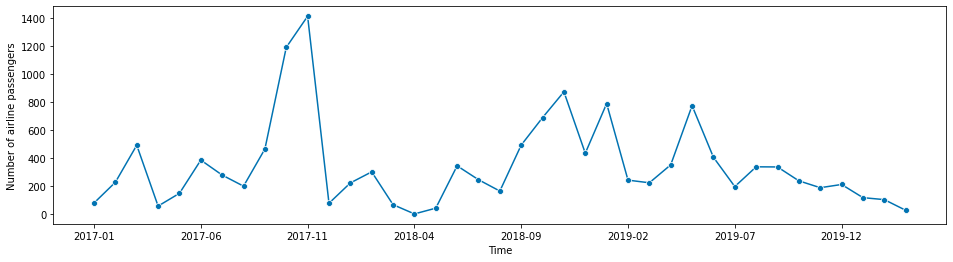

In [7]:
y = pd.Series(agg_data[0], index=pd.period_range(start='2017-01-01', end='2020-03-01', periods=None, freq='M', name='Priod'),
              name='Sales',dtype='float64')
fig, ax = plot_series(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

30 9


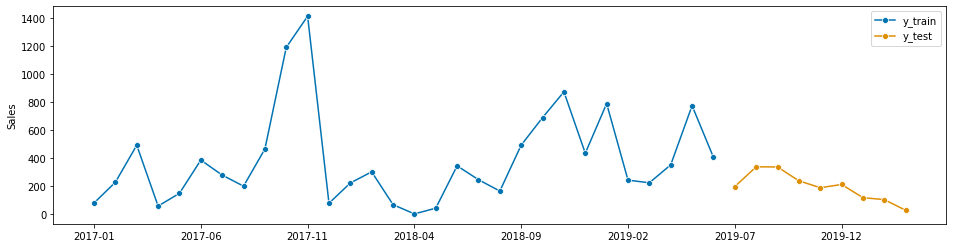

In [8]:
y_train, y_test = temporal_train_test_split(y, test_size=9)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [9]:
fh = np.arange(len(y_test)) + 1
fh

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03'],
            dtype='period[M]', name='Priod', freq='M', is_relative=False)

0.77402203733269

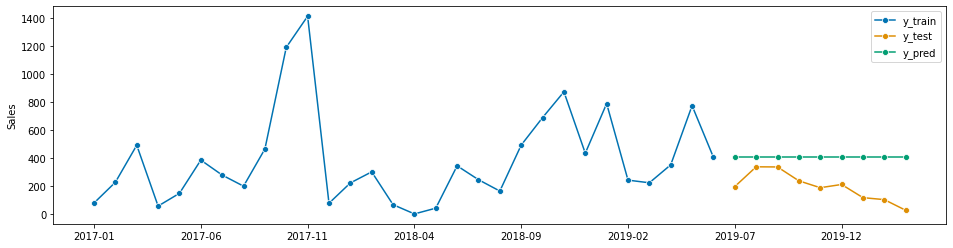

In [11]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.8968676656631798

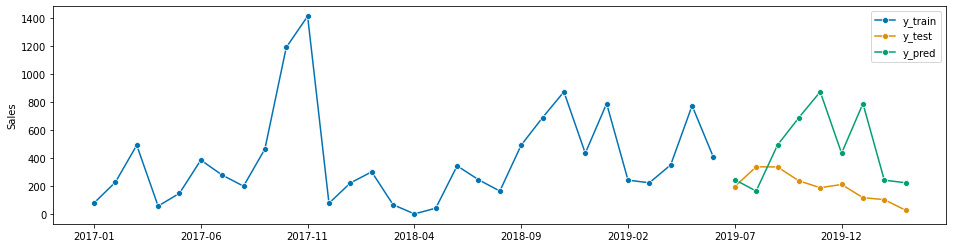

In [12]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.7949241499134386

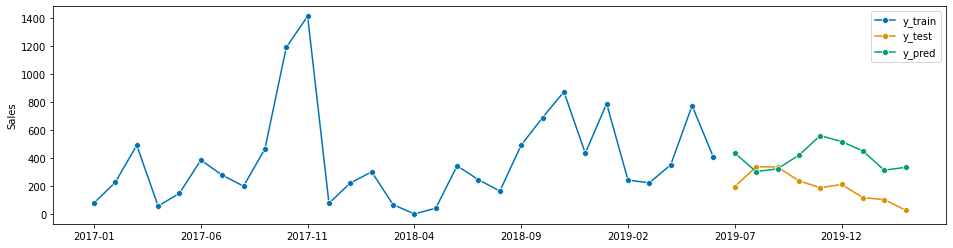

In [13]:
forecaster = ThetaForecaster(sp=6)
forecaster.fit(y_train+1)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.9022894666444243

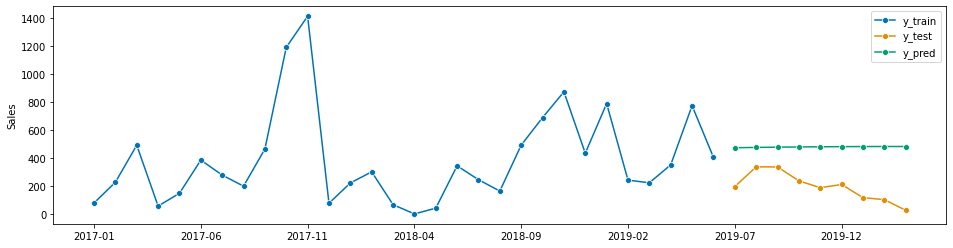

In [14]:
forecaster = PolynomialTrendForecaster(degree=2)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [15]:
y_train, y_test = temporal_train_test_split(y, test_size=9)
print(y_train.shape[0], y_test.shape[0])

30 9


0.8452434674645088

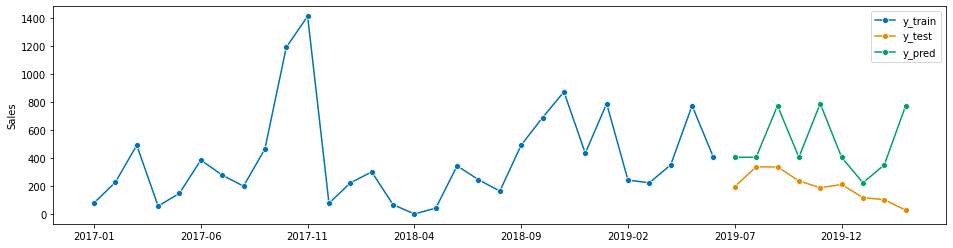

In [16]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=12, strategy="recursive"
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.6256884914831307

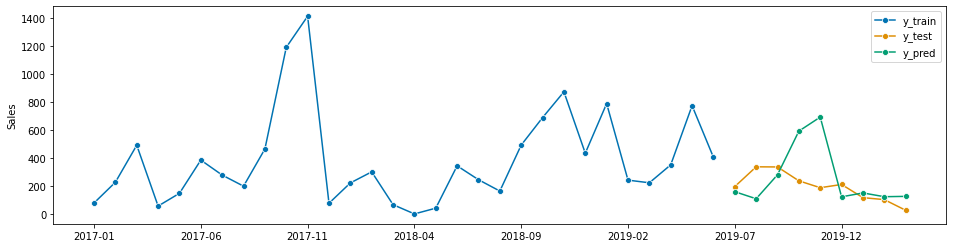

In [17]:
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train+1)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

1.0190124064455608

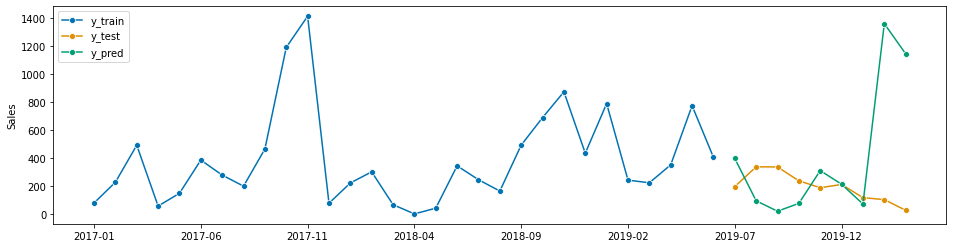

In [18]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train+1)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.7638699509849852

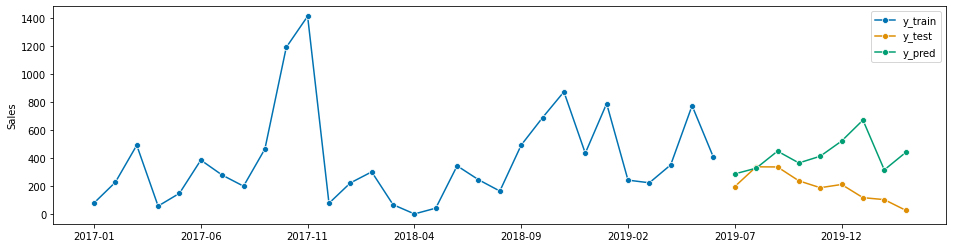

In [19]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.9990275399724953

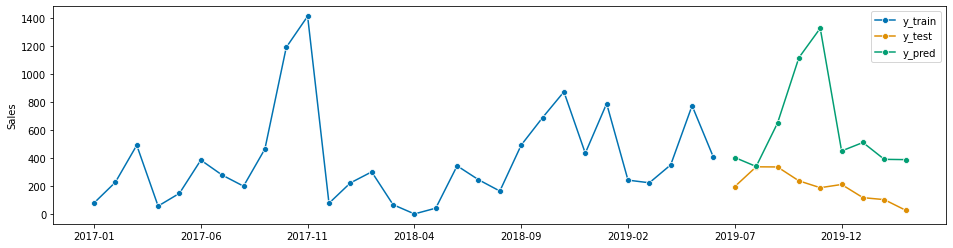

In [20]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

1.1973625239203836

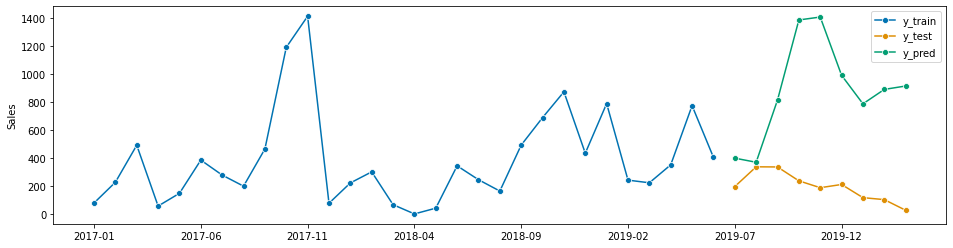

In [21]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.7271131642743315

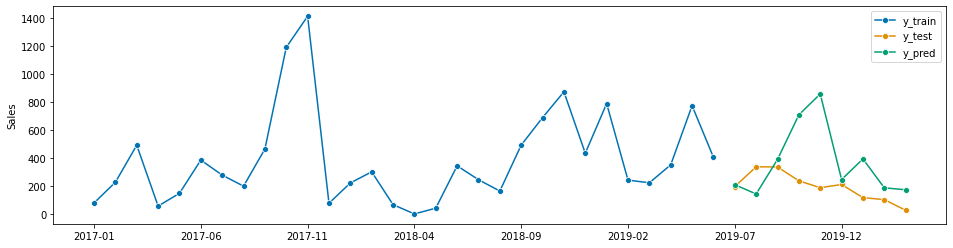

In [22]:
forecaster = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped_trend=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped_trend=True, seasonal="multiplicative", sp=12
            ),
        ),
    ]
)
forecaster.fit(y_train+1)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)